<a href="https://colab.research.google.com/github/APPARAOsiddapureddy/BgColorChange/blob/main/LLM_Fine_Tuning_(Dialogue_Summarization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dialogue Summarization Fine-Tuning




## Resources
- Verify the availability of notebook resources
- Fine-tuning necessitates the use of either a GPU or a TPU

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 13 07:38:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install Libraries
+ hugging face
+ PyTorch
+ Standard Python data science libraries

In [1]:
%pip install transformers datasets evaluate accelerate pipeline bitsandbytes
%pip install torch torchdata
%pip install peft
%pip install loralib
%pip install bert_score
%pip install rouge_score
%pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    GenerationConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    BitsAndBytesConfig
)
import torch
import evaluate
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    PeftConfig,
)
from huggingface_hub import login

### HuggingFace Authentication
+ Authenticate to pull models and datasets (read token required)
+ Authenticate to push models to hugging face hub (write token required)



In [ ]:
login()

### Notebook Config
+ Define some useful constants
+ Device (CPU or CUDA for distributed environments)
+ Model Paths (saving model checkpoints)
+ Setting a template for seaborn plotting

In [5]:
# training directory
MNAME = 'Dialogue'
DIR_TRAIN = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/peft/train/"
DIR_MODEL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/peft/models/"
DIR_EVAL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/{MNAME}/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [6]:
# Color Palettes
colors = {
    "sage"     : "#53808D",
    "orange"   : "#FC4C02",
    "blue"     : "#1B99D6",
    "yellow"   : "#FFF57B",
    "darkgrey" : "#585858",
    "lightgrey": "#D5DADD",
    "lightsage": '#E9F2EF'
}
palette_discete = sns.color_palette([v for k,v in colors.items()])
palette_continuous = sns.color_palette(f"blend:{colors['sage']},{colors['orange']}", as_cmap=True)

# custom theme
rc = {
    'axes.facecolor':f"{colors['lightsage']}",
    "axes.edgecolor":f"{colors['sage']}",
    "text.color":f"{colors['sage']}",
    "axes.labelcolor":f"{colors['sage']}",
    "ytick.color":f"{colors['sage']}",
    "xtick.color":f"{colors['sage']}",
}
sns.set_style('whitegrid',rc =rc)

# set context elements
sns.set_context('notebook',rc={'grid.linewidth':'1.1'})

# set custom palette
sns.set_palette(palette_discete)

palette_discete

[(0.3254901960784314, 0.5019607843137255, 0.5529411764705883),
 (0.9882352941176471, 0.2980392156862745, 0.00784313725490196),
 (0.10588235294117647, 0.6, 0.8392156862745098),
 (1.0, 0.9607843137254902, 0.4823529411764706),
 (0.34509803921568627, 0.34509803921568627, 0.34509803921568627),
 (0.8352941176470589, 0.8549019607843137, 0.8666666666666667),
 (0.9137254901960784, 0.9490196078431372, 0.9372549019607843)]

## FLAN-T5
+ Fine-Tuned-Language-Net [FLAN-T5](https://huggingface.co/docs/transformers/en/model_doc/flan-t5)
+ An encoder-decoder model developed by Google
+ The base model has been fine-tuned on various tasks
+ The [FLAN-T5 base variant]((https://huggingface.co/google/flan-t5-base)) was selected for fine-tuning on text summarization tasks

#### Why FLAN-T5
+ It's a small but powerful LLM
+ Performance is [comparable to larger LLMs](https://www.graphcore.ai/posts/flan-t5-sweet-results-with-the-smaller-more-efficient-llm) on many tasks
+ One of the easier models to implement and fine-tune with many examples available. An ideal model to learn from
+ Use cases include text classification, text summarization, translation and question-answering

### Fine Tuning Dataset: DialogSum

+ [DialogSum](https://huggingface.co/datasets/stanfordnlp/imdb)
+ The dataset consists of conversations(dialogue) and a human generated summary (summary)
+ The authors provided the training splits: train(12.5k), Test(1.5k), Validate (500)


In [7]:
# dialouge summary dataset
data_dialogsum = load_dataset('/dialogsum')
data_dialogsum

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/442k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

### Base Model: FLAN-T5 base
+ The FLAN-T5 base model was fine-tuned using the DialogSum dataset to improve dialoge summarization tasks
+ Source: HuggingFace
+ Implementation: HuggingFace, Torch
+ Steps:
 + Download the pre-trained model
 + Create a tokenizer
 + Define the base model (for fine-tuning)
 + Define the original model (for evaluation)
 + Move the models to the DEVICE (cpu, cuda)

In [8]:
# FLANT5 Base Model
base_model_name = 'google/flan-t5-base'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# base model for training
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map='auto')

# original model for evaluation
original_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map='auto')


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Prompt Engineering & Generation
+ Several convenience functions were developed to assist with standardizing prompts and generating summaries
+ get_prompt: format a T5 prompt
+ get_response: encode the response, generate a summary & decode the response
+ print_summary: print the document, human summary and generated summary for an example
+ generate_summaries: Generate summaries for a list of examples in the dataset

In [9]:
def get_prompt(dialogue):
    """Format prompts for text summarization using FLAN-T5 models"""

    # T5 models require the 'summarize' keyword generate text summaries
    prompt = "Summarize the following conversation:\n\n"
    prompt += f"{dialogue}"
    prompt += "\n\n Summary:"
    return prompt

In [10]:
def get_response(prompt, model, tokenizer):
  """ Generate a text summary from the prompt """

  # tokenize the prompt
  encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
  model_inputs = encoded_input.to(DEVICE)

  # generate the response
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=200,
      )

  # decode the response back to text
  decoded_output = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)[0]

  return decoded_output

In [11]:
def print_example(summary,dialogue ):
  """
  Print the original dialogue, the human summary and
  the generated summary
   """
  # print the summaries
  print(f"Dialogue:{summary['index']}")
  print("="*100)
  print(dialogue)
  print("\nHuman Summary",'-'*88)
  print(summary['human'],'\n')
  print("GenAI Summary",'-'*88)
  print(summary['genai'])
  print("="*100,'\n')


In [12]:
def generate_responses(data, model, tokenizer, indexes, verbose=True):
    """Generate summaries for each example in the dataset"""

    # accumulator
    summaries=[]

    # for each example in the indexes
    for idx in indexes:
        # extract the dialogue text and human summary
        dialogue = data['test'][idx]['dialogue']
        human_summary = data['test'][idx]['summary']

        # prepare the prompt
        prompt = get_prompt(dialogue)

        # get the response
        genai_summary = get_response(prompt, model, tokenizer)

        # summary of results
        summary = {'index':idx,'human':human_summary,'genai':genai_summary}

        # accumulate summaries
        summaries.append(summary)

        # optional print dialogue & summary
        if verbose:
          print_example(summary,dialogue)

    return summaries

In [13]:
# sample generations from the base model
summaries = generate_responses(
    data_dialogsum,
    base_model,
    tokenizer,
    [40,200],
    True
    )

summaries

Dialogue:40
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Human Summary ----------------------------------------------------------------------------------------
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time. 

GenAI Summary ----------------------------------------------------------------------------------------
Tom is late.

Dialogue:200
#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#

[{'index': 40,
  'human': '#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.',
  'genai': 'Tom is late.'},
 {'index': 200,
  'human': "#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.",
  'genai': 'Changing your computer system can help you to get your business noticed.'}]

### Preprocessing
+ The following preprocessing steps were required for instruction fine-tuning for text summarization tasks
	+ Tokenize the inputs and human-generated summaries
	+ Standardize the document lengths using truncation and padding
	+ Format the instruction prompt for T5 models to include the encoded document text and human-generated summaries
+ Apply all transformations to the train, test, and validation datasets

In [14]:
def preprocess(example):
    """Prepare the dataset for instrucion fine-tuning """
    prompt_start = "Summarize the following converstion: \n\n"
    prompt_end = "\n\nSummary:"
    prompt = [prompt_start + d + prompt_end for d in example['dialogue']]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors='pt').input_ids
    example['labels'] = tokenizer(example['summary'], padding="max_length",truncation=True, return_tensors='pt').input_ids

    return example

In [15]:
# preprocess the data (prepare the prompts, tokenize the inputs, remove unnecessary features)
tokenized_datasets = data_dialogsum.map(preprocess, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id','dialogue','summary','topic'])
print(tokenized_datasets)


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1500
    })
})


### Parameter Efficient Fine Tuning (PEFT)
+ The LoRA methodology is used to fine-tune a small number of adaptors during training
 #### Why PEFT/LoRA?
 + This is the preferred method of many practitioners
 + It is effective at improving performance for task-specific fine-tuning
 + It uses much fewer resources than full instruction fine-tuning
 + It only trains a small fraction of model weights (~1%)
 + It prevents catastrophic forgetting when fine-tuning because the base model weights are unchanged.  The adaptors are merged with the original base model weights
  + There is only a small loss of performance when compared to full fine-tuning


### LoRA Configuration
+ **Key Parameters**
+ rank (r)
 + Determines the number of additional parameters introduced during fine-tuning
 + Typical value range =>  4, 8, 16, 32
  + Higher values increase the model's capacity to capture more complex patterns, but also increase computational costs and the likelihood of over-fitting
  + Over-fitting can be mitigated using regularization techniques (lora_dropout, weight decay)
+ LoRA modules (target_modules)
 + Defines which layers the adaptors are added to in the base model
 + The options available depend on the topography of the base model
+ task_type - the task type (summarization, classification, transaction etc.)
+ Steps
	+ Define the LoRA parameters in the LoraConfig object
	+ Prepare the PEFT model from the base model + LoRA config object
	+ View the number of trainable parameters in the PEFT model

In [16]:
lora_config = LoraConfig(
    r = 16, # dimension of adaptors, rank
    lora_alpha=8, # alpha scaling
    target_modules = ["q","v"], # add LoRA adaptors to these layers in the base model
    lora_dropout=0.10, # regularization
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # text summarization
)

# create the PEFT model
peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


### Training
This project aimed to demonstrate how to fine-tune LLMs for specific tasks using public datasets. As the focus was not on performance, no attempt at hyperparameter tuning was undertaken. In most instances, the default hyperparameter values were used
+ **Key Parameters**
+ output_dir - location to save trained adaptor weights
+ learning_rate -set to default
+ auto_find_batch_size - set to auto
+ Logging and evaluation were set to occur after each epoch
+ The data collator is used to automatically pad the text to the longest sequence in each batch

In [17]:
# Training Config
config_training = TrainingArguments(
    output_dir=DIR_TRAIN,
    auto_find_batch_size=True,
    learning_rate=1e-3,
    logging_steps=1,
    max_steps = 150
)
# Trainer
trainer = Trainer(
    model=peft_model,
    args=config_training,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

# train
trainer.train()

# save adaptor weights
trainer.save_model(DIR_MODEL)
# peft_model.push_to_hub('kconstable/dialogue-flant5')

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: apparaosiddapureddy08 (apparaosiddapureddy08-indian-institute-of-information-te) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
1,47.250000
2,48.500000
3,50.500000
4,46.250000
5,43.000000
6,41.250000
7,39.500000
8,37.250000
9,35.750000
10,33.250000


### Merge Base Model & Adapters
+ The trained LoRA adaptors must be merged with the original base model
+ The resulting model consists of the base model plus the trained adaptors





In [18]:
# merge base model + peft adaptors
tuned_model = PeftModel.from_pretrained(
    base_model,
    DIR_MODEL, # LoRA adapters
    torch_dthype=torch.bfloat16,
    trust_remote_code=True,
    is_trainable=False
  )

# tuned_model = tuned_model.merge_and_unload()

### Evaluate Model Performance
+ Evaluating model performance for text summarization is much more complex than regression or classification

#### Qualitative Comparision
 + The summaries below compare the summaries from the base and tuned models
 + The results are similar, and its not easy to determine if the performance has been improved

In [19]:
# sample generations from the base model
print("Original Model")
print("="*100)
generate_responses(
    data_dialogsum,
    original_model,
    tokenizer,
    [4],
    False
  )

Original Model


[{'index': 4,
  'human': "#Person2# decides to follow #Person1#'s suggestions on quitting driving to work and will try to use public transportations.",
  'genai': 'The following are some ways to get around the city.'}]

In [20]:
# sample generations from the tuned model
print("Tuned Model")
print("="*100)
# tuned model
generate_responses(
    data_dialogsum,
    tuned_model,
    tokenizer,
    [4],
    False
  )

Tuned Model


[{'index': 4,
  'human': "#Person2# decides to follow #Person1#'s suggestions on quitting driving to work and will try to use public transportations.",
  'genai': 'If you are stuck in traffic, you may want to consider taking public transport system to work.'}]

### Quantitative Comparision
+ A method to quantitatively compare summaries is required
+ The hugging face library provides several metrics to evaluate summaries.  
	+ The [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge)- compare the generated summary to the human-generated summary and calculate a score (0-1) based on how many n-grams match
	+ The [BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore) - which calculates a similarity score (0-1) between the human summary and the generated summary
+ Several functions were defined to evaluate the base and tuned models for Rouge and BERT scores

+ **Steps:**
  + Randomly select 50 examples from the test dataset (out of sample)
  + Generate summaries for each example from each model
  + Calculate the evaluation metrics
  + Plot the metrics in BoxPlots to compare the median values and distribution of values
  + The tunned model shows a improvements across all evaluation metrics
  + The performance might be improved with hyperparameter tuning
  + The similarity in performance could also be an indicator that the base model already does a good job of text summarization

In [21]:
def get_model_evaluations(summaries):
  """
  Calculate Rouge & BERT scores for each example in the summaries dict
  Calculate an average overall score across all metrics
  """
  # extract the summaries
  genai = [s['genai'] for s in summaries]
  human = [s['human'] for s in summaries]

  # calculate the rouge scores
  rouge = evaluate.load('rouge')
  r = rouge.compute(
    predictions = genai,
    references = human,
    use_aggregator=False,
    use_stemmer=True,
    rouge_types =  ['rouge1','rouge2','rougeL']
   )

  # calculate the BERT score
  bert = evaluate.load("bertscore")
  b = bert.compute(
      predictions = genai,
      references = human,
      lang='en'
  )['f1']

  # merge dicts
  r.update({'bert':b})

  return pd.DataFrame(r)

In [22]:
def plot_evaluation_metrics(scores_base, scores_tuned):
  """Create BoxPlots for each evaluation metric to compare the base & tuned models """
  # add model names
  scores_base['model'] = 'base'
  scores_tuned['model'] = 'tuned'

  # combine as a dataframe, convert to long format for plotting
  df = pd.concat([scores_base,scores_tuned])
  df_long = pd.melt(df, id_vars=['model'],var_name='metric',value_name='score')

  # plot
  plt.figure(figsize=(10,6))
  plot = sns.boxplot(x="metric", y="score",hue="model",data=df_long)
  plot.set(title = "Evaluation Metrics: Base model vs Fine Tuned Model")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


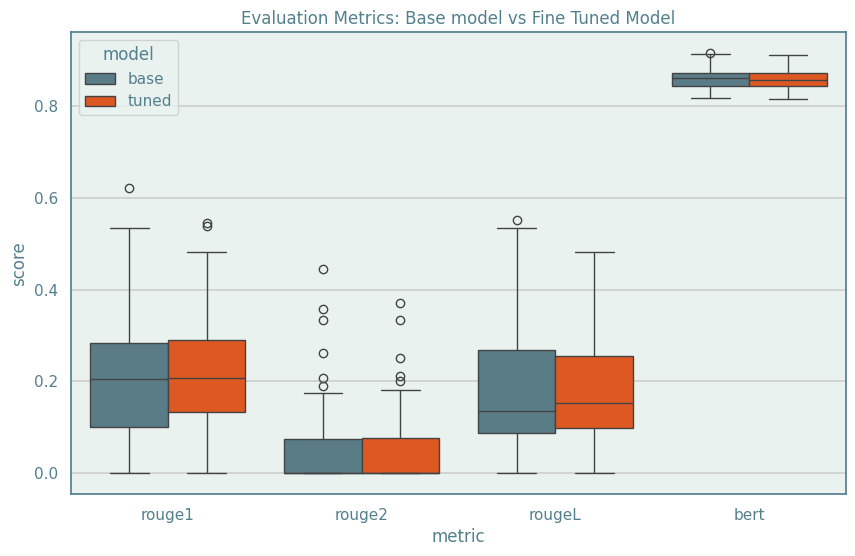

In [23]:
# generate summaries for sample test data
num_samples = data_dialogsum['test'].num_rows-1
num_to_test = 50
test_indexes = random.sample(range(num_samples),num_to_test)

# get responses from each model
summaries_base_model = generate_responses(data_dialogsum, original_model, tokenizer, test_indexes,False)
summaries_tuned_model = generate_responses(data_dialogsum, tuned_model, tokenizer, test_indexes,False)

# Evaluate the performace vs the human labels
# base model:
scores_base = get_model_evaluations(summaries_base_model)

# tuned model
scores_tuned = get_model_evaluations(summaries_tuned_model)

# Plot Results
plot_evaluation_metrics(scores_base, scores_tuned)
